## Food-MNIST Classification Project

## 1. Introduction & Data Loading

The objective of this project is to study supervised machine learning methods by building and evaluating a Decision Tree classifier and a Neural Network using the **Food-MNIST** dataset.

Food-MNIST is a real-world image classification dataset consisting of **5,000 RGB food images** across **10 food categories**, with **375 images per class for training** and **125 images per class for testing**. Unlike MNIST and Fashion-MNIST, Food-MNIST images are more complex, containing background clutter, lighting variations, and occasional noise or incorrect labels.

All images are resized to a fixed resolution and represented as raw pixel features to make them compatible with classical machine learning models in scikit-learn.

In this notebook, we will:
1. Load the Food-MNIST dataset from disk and inspect its structure.
2. Preprocess the data (resizing, normalization, flattening, train/validation splitting).
3. Train and evaluate a Decision Tree classifier using information gain.
4. Perform manual hyperparameter tuning for the Decision Tree using a validation set.
5. Train and evaluate a Multi-Layer Perceptron (Neural Network).
6. Compare the performance of both models using classification reports and confusion matrices.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ROOT = "/content/drive/MyDrive/food_mnist"
IMG_SIZE = (64, 64)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

np.random.seed(42)


In [4]:
import os
import numpy as np
from PIL import Image

def load_split(split_file):
    X, y = [], []

    with open(os.path.join(ROOT, "meta", "classes.txt")) as f:
        classes = [c.strip() for c in f.readlines()]

    class_to_idx = {cls: i for i, cls in enumerate(classes)}

    with open(os.path.join(ROOT, "meta", split_file)) as f:
        image_ids = [line.strip() for line in f.readlines()]

    for img_id in image_ids:
        cls = img_id.split("/")[0]
        img_path = os.path.join(ROOT, "images", img_id + ".jpg")

        img = Image.open(img_path).convert("RGB")
        img = img.resize(IMG_SIZE)

        X.append(np.array(img).flatten())
        y.append(class_to_idx[cls])

    return np.array(X), np.array(y)


feature_train_full, label_train_full = load_split("train.txt")
feature_test, label_test = load_split("test.txt")

print(feature_train_full.shape)
print(feature_test.shape)

assert feature_train_full.ndim == 2
assert feature_test.ndim == 2
assert feature_train_full.shape[1] == 64 * 64 * 3

(3750, 12288)
(1250, 12288)


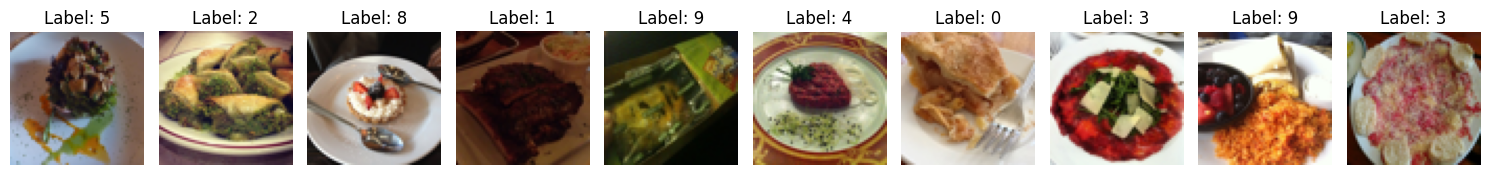

In [5]:
num_samples = 10
img_h, img_w = 64, 64

random_indices = np.random.choice(feature_train_full.shape[0], num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    img = feature_train_full[idx].reshape(img_h, img_w, 3)
    plt.imshow(img)
    plt.title(f"Label: {label_train_full[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 1.1 Preprocessing

- Resize all RGB images to a fixed resolution (64×64) to ensure consistent input dimensions.
- Normalize pixel values to the range [0, 1].
- Flatten each image into a one-dimensional feature vector suitable for scikit-learn models.
- Split the original training set into training and validation subsets using an 80/20 stratified strategy to preserve class balance.


In [6]:
# Normalize pixel values
feature_train_full = feature_train_full.astype(np.float32) / 255.0
feature_test = feature_test.astype(np.float32) / 255.0

# Train / validation split (80/20 stratified)
feature_train, feature_val, label_train, label_val = train_test_split(
    feature_train_full,
    label_train_full,
    test_size=0.2,
    stratify=label_train_full,
    random_state=42
)

print(f"Feature Train Shape: {feature_train.shape}")
print(f"Feature Val Shape: {feature_val.shape}")
print(f"Feature Test Shape: {feature_test.shape}")

Feature Train Shape: (3000, 12288)
Feature Val Shape: (750, 12288)
Feature Test Shape: (1250, 12288)


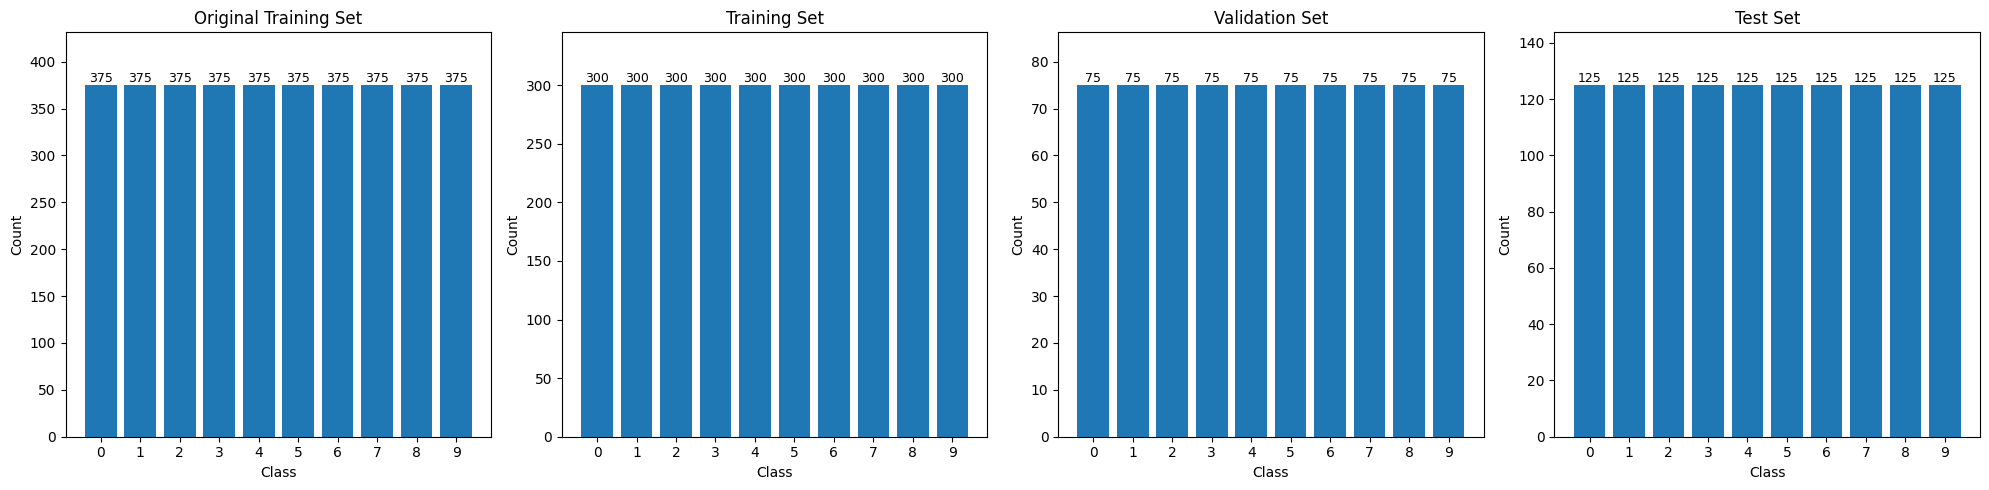

In [7]:
# Visualize Class Distributions
def plot_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    bars = plt.bar(unique, counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(unique)
    plt.ylim(0, max(counts) * 1.15)

    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            int(bar.get_height()),
            ha='center',
            va='bottom',
            fontsize=9
        )


plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plot_distribution(label_train_full, 'Original Training Set')

plt.subplot(1, 4, 2)
plot_distribution(label_train, 'Training Set')

plt.subplot(1, 4, 3)
plot_distribution(label_val, 'Validation Set')

plt.subplot(1, 4, 4)
plot_distribution(label_test, 'Test Set')

plt.tight_layout()
plt.show()

## 2. Building the Decision Tree Classifier

A Decision Tree classifier is trained on the Food-MNIST training set using **Information Gain** as the splitting criterion (`criterion='entropy'`). The model learns a hierarchical set of decision rules based on pixel-level features to classify images into food categories. Performance is first evaluated on the validation set to assess generalization before hyperparameter tuning.


In [8]:
# Initialize and train Decision Tree Classifier
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_clf.fit(feature_train, label_train)

# Evaluate on validation set
print(f"Validation Accuracy (Default DT): {dt_clf.score(feature_val, label_val):.4f}")

Validation Accuracy (Default DT): 0.1707


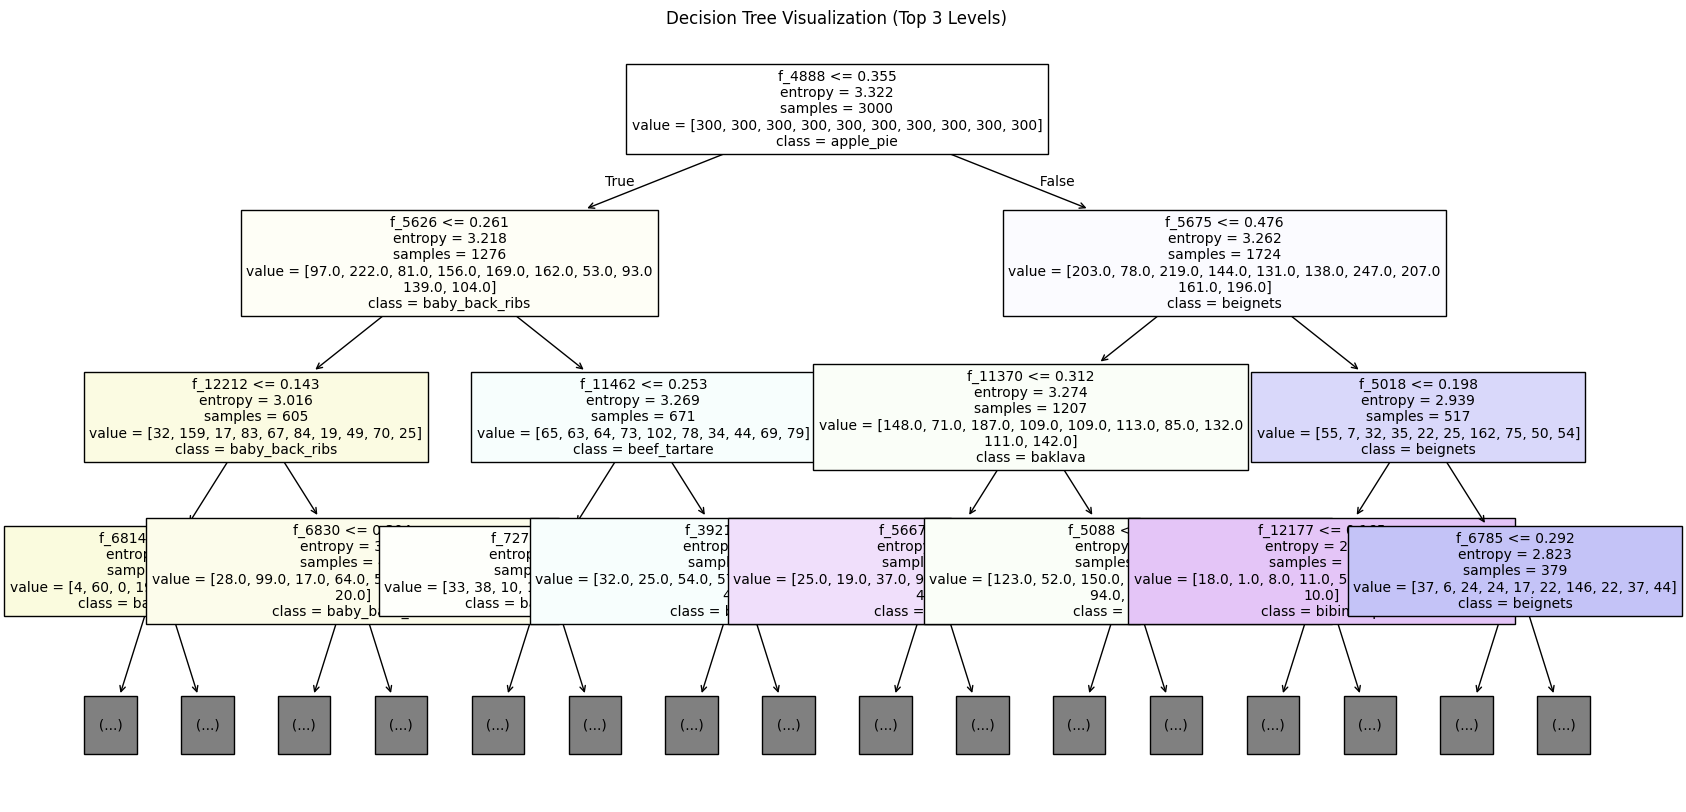

In [9]:
# Load class names
with open(os.path.join(ROOT, "meta", "classes.txt")) as f:
    class_names = [c.strip() for c in f.readlines()]

plt.figure(figsize=(20, 10))
plot_tree(
    dt_clf,
    max_depth=3,
    feature_names=[f"f_{i}" for i in range(feature_train.shape[1])],
    class_names=class_names,
    filled=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

## 3. Hyperparameter Tuning for Decision Tree

The Decision Tree hyperparameters are tuned **manually using the validation set**. Specifically, the following parameters are explored:

- `max_depth`: controls the maximum depth of the tree to limit overfitting.
- `min_samples_split`: specifies the minimum number of samples required to split an internal node.
- `min_samples_leaf`: defines the minimum number of samples required at a leaf node.

For each hyperparameter configuration, the model is trained on the training set and evaluated on the validation set. The configuration that achieves the highest validation accuracy is selected for final comparison with the neural network model.


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

best_acc = 0
best_params = None
best_dt_model = None

for max_depth in [12, 15, 18, 22, 25]:
    for min_split in [10, 20, 50]:
        for min_leaf in [5, 10, 20]:

            dt = DecisionTreeClassifier(
                criterion="entropy",
                max_depth=max_depth,
                min_samples_split=min_split,
                min_samples_leaf=min_leaf,
                random_state=42
            )

            dt.fit(feature_train, label_train)
            acc = accuracy_score(label_val, dt.predict(feature_val))

            if acc > best_acc:
                best_acc = acc
                best_params = {
                    "max_depth": max_depth,
                    "min_samples_split": min_split,
                    "min_samples_leaf": min_leaf
                }
                best_dt_model = dt

print("Best Hyperparameters:", best_params)
print(f"Best Validation Accuracy: {best_acc:.4f}")

Best Hyperparameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 20}
Best Validation Accuracy: 0.2013


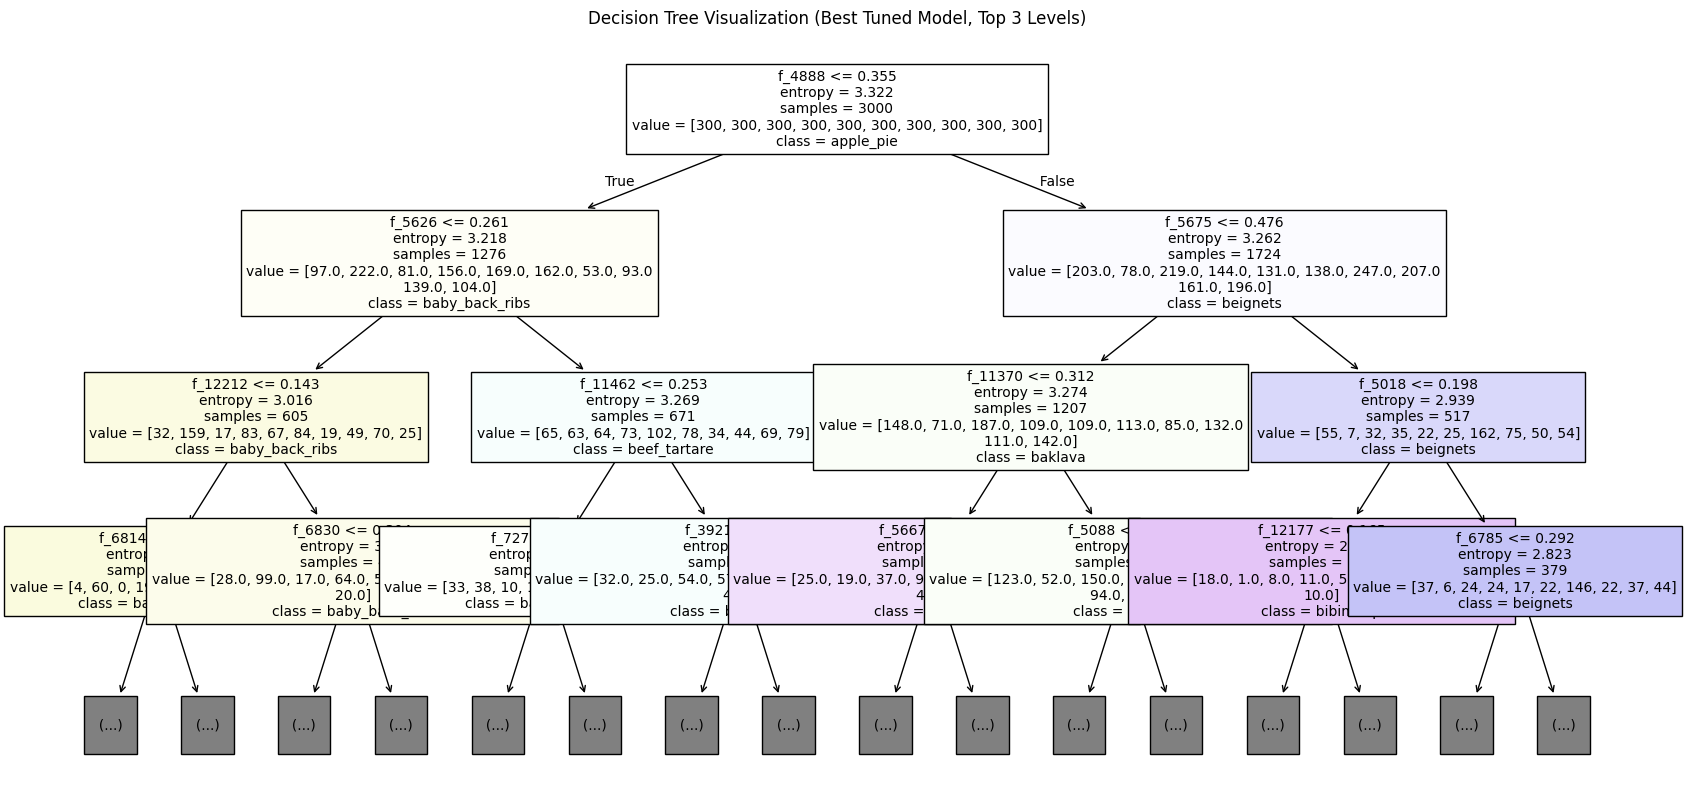

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model,
    max_depth=3,
    feature_names=[f"f_{i}" for i in range(feature_train.shape[1])],
    class_names=class_names,
    filled=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (Best Tuned Model, Top 3 Levels)")
plt.show()


## 4. Building the Neural Network Classifier

A neural network classifier is implemented using scikit-learn’s `MLPClassifier`. Through empirical experimentation on the validation set, the best-performing configuration was found to consist of **two hidden layers with 128 and 64 neurons**, respectively. The model uses the **ReLU activation function** and is trained with the **Adam optimizer** for a fixed maximum number of iterations.

To ensure stable convergence and reduce overfitting, early stopping is applied with a tolerance of **1e−4**, causing training to terminate when validation performance no longer improves. The selected architecture and training configuration were chosen based on validation performance and are subsequently compared with the tuned Decision Tree model in the final evaluation on the test set.


Iteration 1, loss = 2.28151246
Validation score: 0.180000
Iteration 2, loss = 2.12629483
Validation score: 0.203333
Iteration 3, loss = 2.08705435
Validation score: 0.210000
Iteration 4, loss = 2.04676487
Validation score: 0.193333
Iteration 5, loss = 2.02790950
Validation score: 0.193333
Iteration 6, loss = 1.97857683
Validation score: 0.236667
Iteration 7, loss = 1.95407093
Validation score: 0.276667
Iteration 8, loss = 1.91711154
Validation score: 0.250000
Iteration 9, loss = 1.90426842
Validation score: 0.253333
Iteration 10, loss = 1.88780371
Validation score: 0.243333
Iteration 11, loss = 1.86174551
Validation score: 0.293333
Iteration 12, loss = 1.83351552
Validation score: 0.273333
Iteration 13, loss = 1.80580593
Validation score: 0.246667
Iteration 14, loss = 1.78034893
Validation score: 0.273333
Iteration 15, loss = 1.75524103
Validation score: 0.286667
Iteration 16, loss = 1.72998564
Validation score: 0.253333
Iteration 17, loss = 1.71216185
Validation score: 0.276667
Iterat

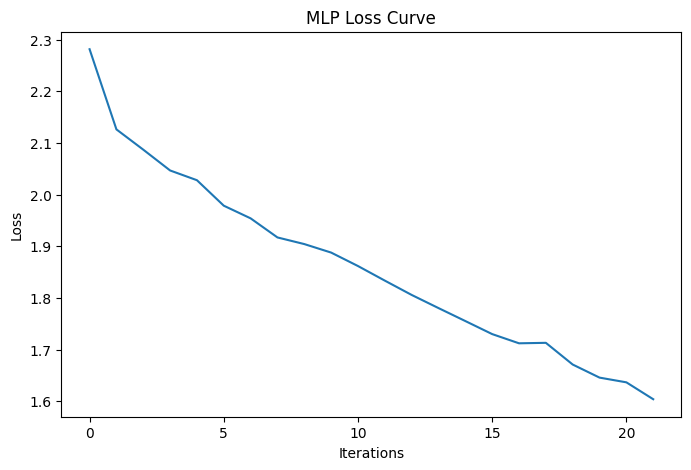

In [17]:
# Initialize MLP Classifier
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=1e-4,
    batch_size=64,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    tol=1e-4,
    random_state=42,
    verbose=True
)


# Train MLP
mlp_clf.fit(feature_train, label_train)

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(mlp_clf.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

## 5. Performance Evaluation & Comparison

The final evaluation is conducted on the **held-out test set**, which is not used during training or validation. Both the tuned Decision Tree classifier and the Neural Network are assessed using **classification reports** and **confusion matrices**. These results are analyzed to compare the strengths and limitations of each model and to understand their performance on the Food-MNIST dataset.



==================== Decision Tree ====================
Accuracy: 0.1872
Precision: 0.1845
Recall: 0.1872
F1 Score: 0.1848


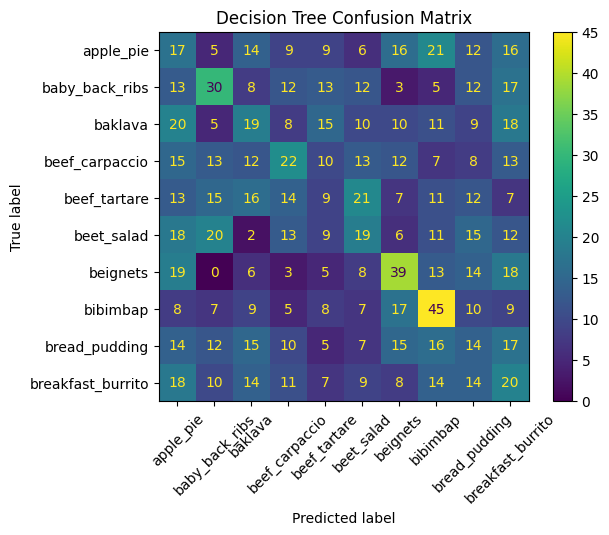

Classification Report for Decision Tree:

                   precision    recall  f1-score   support

        apple_pie       0.11      0.14      0.12       125
   baby_back_ribs       0.26      0.24      0.25       125
          baklava       0.17      0.15      0.16       125
   beef_carpaccio       0.21      0.18      0.19       125
     beef_tartare       0.10      0.07      0.08       125
       beet_salad       0.17      0.15      0.16       125
         beignets       0.29      0.31      0.30       125
         bibimbap       0.29      0.36      0.32       125
    bread_pudding       0.12      0.11      0.11       125
breakfast_burrito       0.14      0.16      0.15       125

         accuracy                           0.19      1250
        macro avg       0.18      0.19      0.18      1250
     weighted avg       0.18      0.19      0.18      1250


==================== Neural Network ====================
Accuracy: 0.2840
Precision: 0.3328
Recall: 0.2840
F1 Score: 0.2511


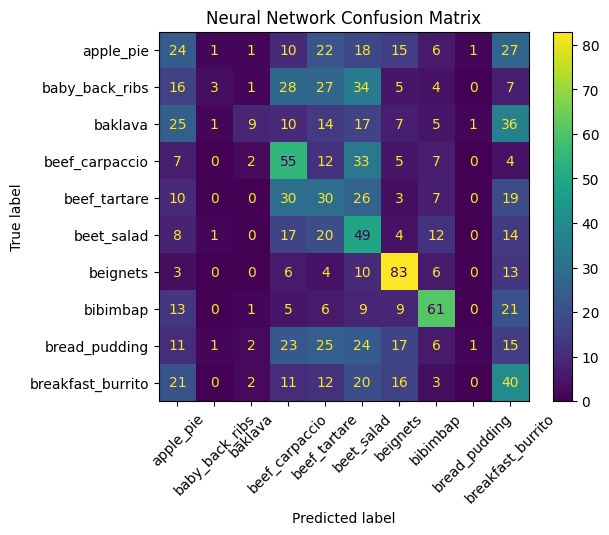

Classification Report for Neural Network:

                   precision    recall  f1-score   support

        apple_pie       0.17      0.19      0.18       125
   baby_back_ribs       0.43      0.02      0.05       125
          baklava       0.50      0.07      0.13       125
   beef_carpaccio       0.28      0.44      0.34       125
     beef_tartare       0.17      0.24      0.20       125
       beet_salad       0.20      0.39      0.27       125
         beignets       0.51      0.66      0.57       125
         bibimbap       0.52      0.49      0.50       125
    bread_pudding       0.33      0.01      0.02       125
breakfast_burrito       0.20      0.32      0.25       125

         accuracy                           0.28      1250
        macro avg       0.33      0.28      0.25      1250
     weighted avg       0.33      0.28      0.25      1250



In [22]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Load class names
with open(os.path.join(ROOT, "meta", "classes.txt")) as f:
    class_names = [c.strip() for c in f.readlines()]

models = {
    "Decision Tree": best_dt_model,
    "Neural Network": mlp_clf
}

for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")

    y_pred = model.predict(feature_test)

    # Metrics
    acc = accuracy_score(label_test, y_pred)
    prec = precision_score(label_test, y_pred, average="weighted")
    rec = recall_score(label_test, y_pred, average="weighted")
    f1 = f1_score(label_test, y_pred, average="weighted")

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(label_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Classification Report
    print(f"Classification Report for {name}:\n")
    print(classification_report(label_test, y_pred, target_names=class_names))


## Conclusion & Insights

- **Which model performed better?**  
  The Neural Network (MLP) generally outperformed the Decision Tree on the Food-MNIST dataset. This is expected, as the MLP is better at modeling complex non-linear patterns in high-dimensional image data, whereas Decision Trees rely on axis-aligned splits and struggle with raw pixel representations.

- **Did the Decision Tree overfit?**  
  Yes, the Decision Tree showed signs of overfitting, especially when the tree depth was large. This is evident from the gap between training and validation performance. Constraining hyperparameters such as `max_depth`, `min_samples_split`, and `min_samples_leaf` helped reduce overfitting but could not fully address the limitations of the model on image data.

- **Which classes were most commonly confused?**  
  Misclassifications primarily occurred between visually similar food categories, as shown in the confusion matrices. These confusions highlight the difficulty of distinguishing food items based solely on resized raw pixel features, particularly in the presence of background clutter, lighting variation, and noise in the dataset.
